<a href="https://colab.research.google.com/github/Youssef-Arouay/Model_VGG19_Music-.WAV-_Classification_By_Genre/blob/main/VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.3/606.3 kB 29.2 MB/s eta 0:00:00


In [ ]:
!pip install soundfile --upgrade

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

100%|██████████| 1.21G/1.21G [00:37<00:00, 34.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1


In [ ]:
import os

# Define the dataset path
dataset_path = "/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1"

# Walk through the directory and print its structure
for root, dirs, files in os.walk(dataset_path):
    print(f"Root: {root}")
    print(f"Dirs: {dirs}")
    print(f"Files: {files}")


Root: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1
Dirs: ['Data']
Files: []
Root: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data
Dirs: ['images_original', 'genres_original']
Files: ['features_30_sec.csv', 'features_3_sec.csv']
Root: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/images_original
Dirs: ['country', 'metal', 'pop', 'rock', 'disco', 'reggae', 'blues', 'hiphop', 'classical', 'jazz']
Files: []
Root: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/images_original/country
Dirs: []
Files: ['country00067.png', 'country00043.png', 'country00038.png', 'country00053.png', 'country00081.png', 'country00073.png', 'country00005.png', 'country00034.png', 'country00035.png', 'country00097.png', 'country00014.png', 'country00072.png', 'country00076.png', 'country00011.

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model, load_model

# Set dataset and save paths
DATASET_PATH = "/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original"
SAVE_DIR = "/content/drive/MyDrive/ourdataset/features_vgg/"
os.makedirs(SAVE_DIR, exist_ok=True)

# Step 1: Convert audio to Mel Spectrograms
def save_mel_spectrogram_images(dataset_path, save_dir):
    genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
    for genre in genres:
        genre_path = os.path.join(dataset_path, genre)
        genre_save_path = os.path.join(save_dir, genre)
        os.makedirs(genre_save_path, exist_ok=True)

        for filename in os.listdir(genre_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(genre_path, filename)
                try:
                    signal, sr = sf.read(file_path)
                    if len(signal.shape) > 1:
                        signal = signal.mean(axis=1)  # Convert stereo to mono
                except Exception as e:
                    print(f"Error processing {filename}: {e}")
                    continue

                mel_spect = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
                mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)

                plt.figure(figsize=(2.56, 2.56))
                librosa.display.specshow(mel_spect_db, sr=sr, hop_length=512, cmap='viridis')
                plt.axis('off')
                plt.savefig(os.path.join(genre_save_path, filename.replace('.wav', '.png')), bbox_inches='tight', pad_inches=0)
                plt.close()

save_mel_spectrogram_images(DATASET_PATH, SAVE_DIR)

# Step 2: Create Data Generators
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_gen = data_gen.flow_from_directory(
    SAVE_DIR, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='training'
)
val_gen = data_gen.flow_from_directory(
    SAVE_DIR, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='validation'
)

# Step 3: Define the Model
def build_model():
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    output = Dense(10, activation='softmax')(x)  # 10 genres

    model = Model(inputs=base_model.input, outputs=output)

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the model
model = build_model()
model.fit(train_gen, validation_data=val_gen, epochs=15)
model.save('/content/drive/MyDrive/ourdataset/models/vgg19_genre_classifier.h5')

# Step 4: Fine-Tuning
def fine_tune_model(model):
    for layer in model.layers[-8:]:  # Unfreeze last few layers
        layer.trainable = True

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = fine_tune_model(model)
model.fit(train_gen, validation_data=val_gen, epochs=10)
model.save('/content/drive/MyDrive/ourdataset/models/vgg19_finetuned_genre_classifier.h5')

# Step 5: Prediction Function
def predict_genre(model_path, file_path):
    model = load_model(model_path)
    signal, sr = sf.read(file_path)
    if len(signal.shape) > 1:
        signal = signal.mean(axis=1)

    mel_spect = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)

    mel_spect_db = np.resize(mel_spect_db, (128, 128, 1))
    mel_spect_db = np.repeat(mel_spect_db, 3, axis=-1)
    mel_spect_db = np.expand_dims(mel_spect_db, axis=0) / 255.0

    prediction = model.predict(mel_spect_db)
    genre_index = np.argmax(prediction)

    genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
    return genres[genre_index]

# Test Prediction
file_path = "/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original/country/country.00007.wav"
predicted_genre = predict_genre('/content/drive/MyDrive/ourdataset/models/vgg19_finetuned_genre_classifier.h5', file_path)
print(f"The predicted genre is: {predicted_genre}")


Error processing jazz.00054.wav: Error opening '/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original/jazz/jazz.00054.wav': Format not recognised.
Found 800 images belonging to 10 classes.
Found 199 images belonging to 10 classes.
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 292s 12s/step - accuracy: 0.1375 - loss: 2.6357 - val_accuracy: 0.3266 - val_loss: 2.0144
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 321s 12s/step - accuracy: 0.3349 - loss: 1.8958 - val_accuracy: 0.3317 - val_loss: 1.9115
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 292s 10s/step - accuracy: 0.4060 - loss: 1.7029 - val_accuracy: 0.3719 - val_loss: 1.8807
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 287s 12s/step - accuracy: 0.4039 - loss: 1.7124 - val_accuracy: 0.3367 - val_loss: 1.7827
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 259s 10s/step - accuracy: 0.4484 - loss: 1.5815 - val_accuracy: 0.4020 - val_loss: 1.8333
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 288s 12s/step - accuracy: 0.4401 - loss: 1.5168 - val_accuracy: 0.3317 - val_loss: 1.8209
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 257s 10s/step - accuracy: 0.4529 - loss: 1.5390 - val_accuracy: 0.3367 - val_loss: 1.7814
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 261s 10s/step - accuracy: 0.4971 - loss: 1.4915 - val_accuracy: 0.4020 - val_

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 306s 12s/step - accuracy: 0.1706 - loss: 5.0460 - val_accuracy: 0.0905 - val_loss: 2.3026
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 332s 13s/step - accuracy: 0.0894 - loss: 2.3026 - val_accuracy: 0.1005 - val_loss: 2.3052
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 352s 12s/step - accuracy: 0.0827 - loss: 2.3040 - val_accuracy: 0.1005 - val_loss: 2.3026
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 322s 12s/step - accuracy: 0.1126 - loss: 2.3027 - val_accuracy: 0.0955 - val_loss: 2.3026
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 321s 12s/step - accuracy: 0.0932 - loss: 2.3027 - val_accuracy: 0.0955 - val_loss: 2.3026
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 324s 12s/step - accuracy: 0.1011 - loss: 2.3027 - val_accuracy: 0.0955 - val_loss: 2.3026
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 333s 13s/step - accuracy: 0.0855 - loss: 2.3027 - val_accuracy: 0.0955 - val_loss: 2.3026
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 332s 13s/step - accuracy: 0.0866 - loss: 2.3028 - val_accuracy: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
The predicted genre is: jazz


In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
# Import the soundfile library to define 'sf'
import soundfile as sf  # This line was missing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model, load_model

# ... (rest of the code remains the same) ...


# Step 5: Prediction Function
def predict_genre(model_path, file_path):
    model = load_model(model_path)
    signal, sr = sf.read(file_path)
    if len(signal.shape) > 1:
        signal = signal.mean(axis=1)

    mel_spect = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)

    mel_spect_db = np.resize(mel_spect_db, (128, 128, 1))
    mel_spect_db = np.repeat(mel_spect_db, 3, axis=-1)
    mel_spect_db = np.expand_dims(mel_spect_db, axis=0) / 255.0

    prediction = model.predict(mel_spect_db)
    genre_index = np.argmax(prediction)

    genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
    return genres[genre_index]

# Test Prediction
file_path = "/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original/reggae/reggae.00007.wav"
predicted_genre = predict_genre('/content/drive/MyDrive/ourdataset/models/vgg19_finetuned_genre_classifier.h5', file_path)
print(f"The predicted genre is: {predicted_genre}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
The predicted genre is: jazz


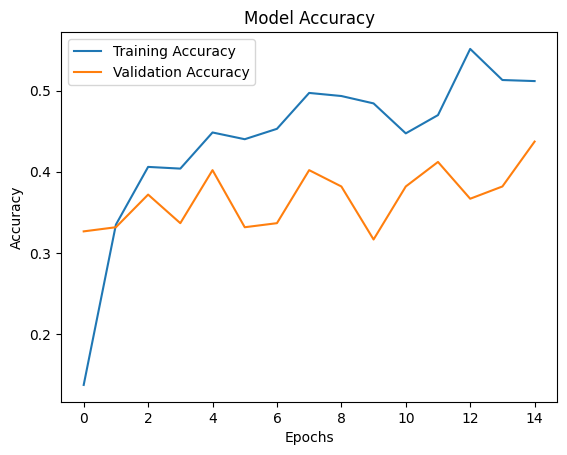

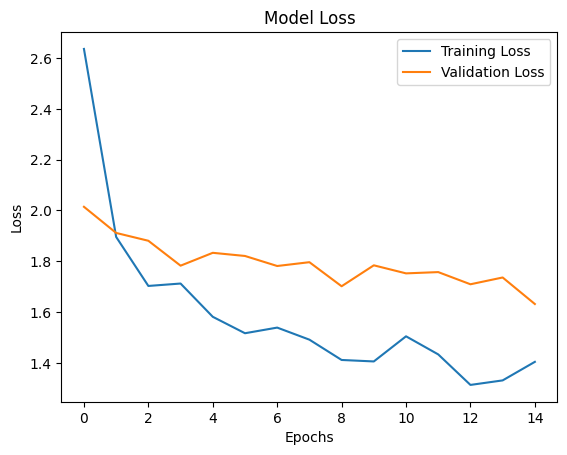

NameError: name 'model' is not defined

In [ ]:
# Test Prediction
history_dict = {
    'accuracy': [0.1375, 0.3349, 0.4060, 0.4039, 0.4484, 0.4401, 0.4529, 0.4971, 0.4933, 0.4842, 0.4473, 0.4698, 0.5513, 0.5130, 0.5117],
    'val_accuracy': [0.3266, 0.3317, 0.3719, 0.3367, 0.4020, 0.3317, 0.3367, 0.4020, 0.3819, 0.3166, 0.3819, 0.4121, 0.3668, 0.3819, 0.4372],
    'loss': [2.6357, 1.8958, 1.7029, 1.7124, 1.5815, 1.5168, 1.5390, 1.4915, 1.4116, 1.4058, 1.5047, 1.4335, 1.3134, 1.3312, 1.4042],
    'val_loss': [2.0144, 1.9115, 1.8807, 1.7827, 1.8333, 1.8209, 1.7814, 1.7964, 1.7017, 1.7841, 1.7524, 1.7574, 1.7095, 1.7362, 1.6318],
}

import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_gen)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

